In [1]:
import tensorflow as tf
print("tensorflow version is", tf.__version__)
print("keras version is", tf.keras.__version__)

from tensorflow.keras.models import load_model
import itertools
import math
import random
import matplotlib.pyplot as plt
import numpy as np
plt.ioff()  # not to show images inline

tensorflow version is 2.1.0
keras version is 2.2.4-tf


In [2]:
generator = load_model("out4/celeba-generator_0050000.h5")

(40, 80, 80, 3) 0 254


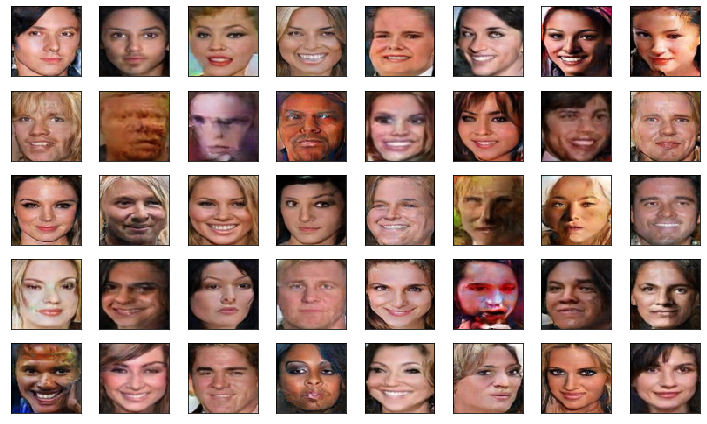

In [3]:
def plot_images(images, nrow=5, ncol=8, figsize=(10, 6)):
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    for i, j in itertools.product(range(nrow), range(ncol)):
        k = i*ncol + j
        if nrow > 1 and ncol > 1:
            a = ax[i][j] 
        elif nrow > 1:
            a = ax[i]
        elif ncol > 1:
            a = ax[j]
        else:
            a = ax
        if k < len(images):
            a.imshow(images[k])
        a.xaxis.set_visible(False)
        a.yaxis.set_visible(False)
    fig.tight_layout()
    plt.close(fig)
    return fig

def generate_latent(generator, n_sample=128, seed=None):
    np.random.seed(seed)
    latent_size = generator.input_shape[1]
    latent = np.random.randn(n_sample, latent_size)
    return latent

def generate_faces(generator, latents):
    faces = generator.predict(latents)
    faces = ((faces+1)*255/2).astype(int)
    return faces

latents = generate_latent(generator, 40)
faces = generate_faces(generator, latents)
print(faces.shape, np.min(faces), np.max(faces))
plot_images(faces, nrow=5, ncol=8)

(11, 100)


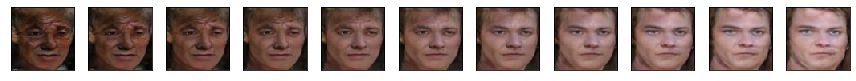

In [4]:
def interpolate_linear(p1, p2, n=9):
    interval = 1/(n+1)  # split (0, 1) to n parts
    ratios = np.arange(0, 1+interval, interval) # add interval for including 1
    points = [p1*(1-r) + p2*r for r in ratios]
    points = np.array(points)
    return points
# test
p1, p2 = generate_latent(generator, 2)
points = interpolate_linear(p1, p2)
print(points.shape) # 10 + two end points
faces = generate_faces(generator, points)
plot_images(faces, nrow=1, ncol=11, figsize=(12, 1.2))

(11, 100)


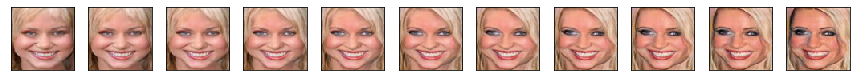

In [5]:
def interpolate_slerp(p1, p2, n=9, dot_thres=0.9995):
    norm1 = np.linalg.norm(p1)
    norm2 = np.linalg.norm(p2)
    dot = np.sum((p1/norm1) * (p2/norm2))
    if abs(dot) > dot_thres:
        print("dot is {}. Switch to linear")
        return interpolate_linear(p1, p2, n=n)
    else:
        omega = math.acos(max(-1, min(1, dot)))
        sinomega = math.sin(omega)        
        interval = 1/(n+1)  # split (0, 1) to n parts
        ratios = np.arange(0, 1+interval, interval) # add interval for including 1
        points = [p1*math.sin((1-r)*omega)/sinomega + p2*math.sin(r*omega)/sinomega for r in ratios]
        points = np.array(points)
        return points
# test
p1, p2 = generate_latent(generator, 2)
points = interpolate_slerp(p1, p2)
print(points.shape) # 10 + two end points
faces = generate_faces(generator, points)
plot_images(faces, nrow=1, ncol=11, figsize=(12, 2))

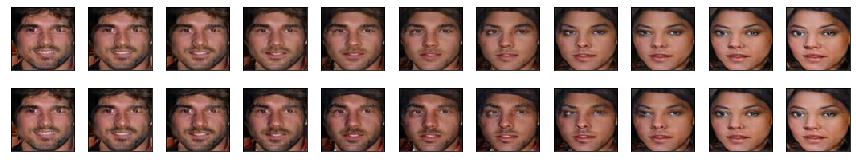

In [6]:
# comparison linear vs slerp
p1, p2 = generate_latent(generator, 2)
points_linear = interpolate_linear(p1, p2)
points_slerp = interpolate_slerp(p1, p2)
points = np.concatenate((points_linear, points_slerp), axis=0)
faces = generate_faces(generator, points)
plot_images(faces, nrow=2, ncol=11, figsize=(12, 2.5))

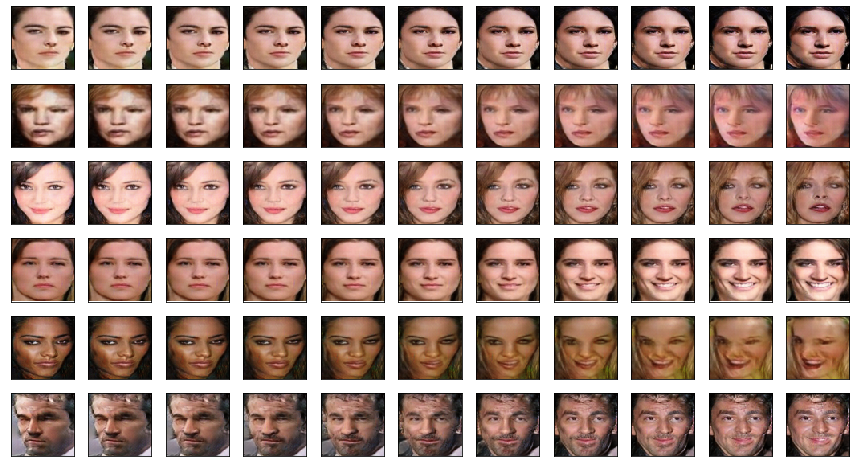

In [7]:
# linear
faces = None
nrow = 6
for j in range(nrow):
    p1, p2 = generate_latent(generator, 2, seed=j) # generate same images as slerp
    points = interpolate_linear(p1, p2)
    tmp = generate_faces(generator, points)
    faces = tmp if faces is None else np.concatenate((faces, tmp), axis=0)
plot_images(faces, nrow=nrow, ncol=11, figsize=(12, 1.1*nrow))    

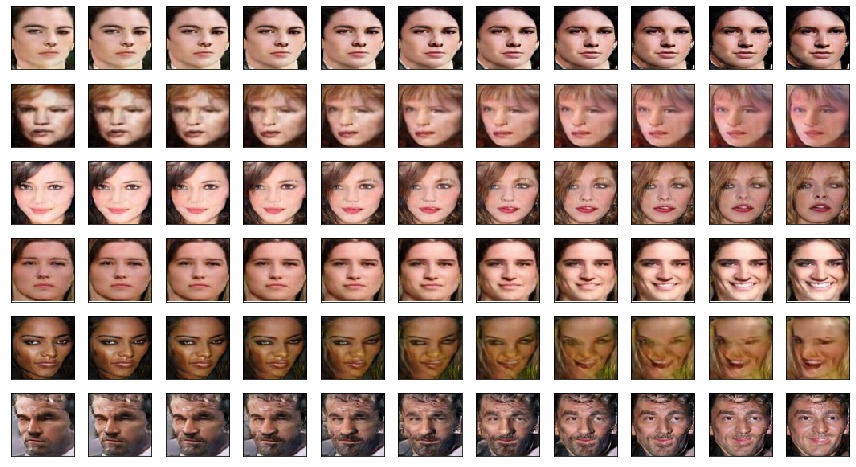

In [8]:
# slerp
faces = None
nrow = 6
for j in range(nrow):
    p1, p2 = generate_latent(generator, 2, seed=j)  # generate same image as linear
    points = interpolate_slerp(p1, p2)
    tmp = generate_faces(generator, points)
    faces = tmp if faces is None else np.concatenate((faces, tmp), axis=0)
plot_images(faces, nrow=nrow, ncol=11, figsize=(12, 1.1*nrow))    

(50, 80, 80, 3) 0 254


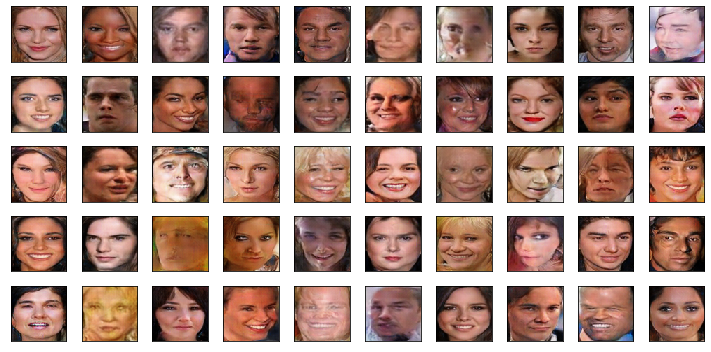

In [9]:
latents = generate_latent(generator, 50, seed=875)
faces = generate_faces(generator, latents)
print(faces.shape, np.min(faces), np.max(faces))
plot_images(faces, nrow=5, ncol=10, figsize=(10, 5))

In [10]:
smiling_woman = [0,1,12,24,25,29,30,36]
neutral_woman = [7,18,19,23,35,42]
smiling_man = [4,8,22,44,48]
neutral_man = [2,3,11,31,38,39,45]

def show_average(points):
    src = generate_faces(generator, points)
    avg = generate_faces(generator,
                         np.mean(points, axis=0, keepdims=True))
    display(plot_images(src, nrow=1, ncol=len(points), figsize=(1.5*len(points),3)))
    display(plot_images(avg, nrow=1, ncol=1, figsize=(2,2)))

Smiling women


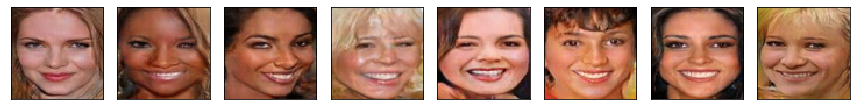

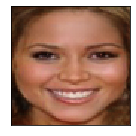

In [11]:
print("Smiling women")
show_average(latents[smiling_woman])

Neutral women


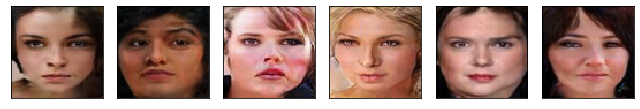

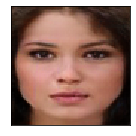

In [12]:
print("Neutral women")
show_average(latents[neutral_woman])

Smiling men


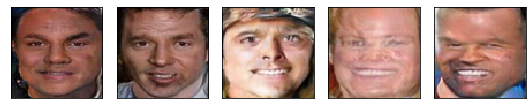

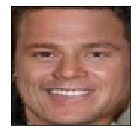

In [13]:
print("Smiling men")
show_average(latents[smiling_man])

Neutral men


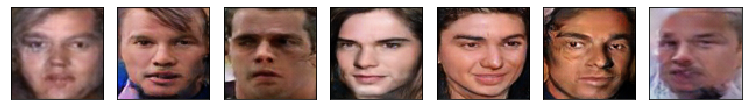

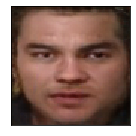

In [14]:
print("Neutral men")
show_average(latents[neutral_man])

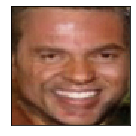

In [15]:
# smiling_woman - neutral_woman + neutral_man
point = np.mean(latents[smiling_woman], axis=0, keepdims=True) -\
        np.mean(latents[neutral_woman], axis=0, keepdims=True) +\
        np.mean(latents[neutral_man], axis=0, keepdims=True)
res = generate_faces(generator, point)
plot_images(res, nrow=1, ncol=1, figsize=(2,2))

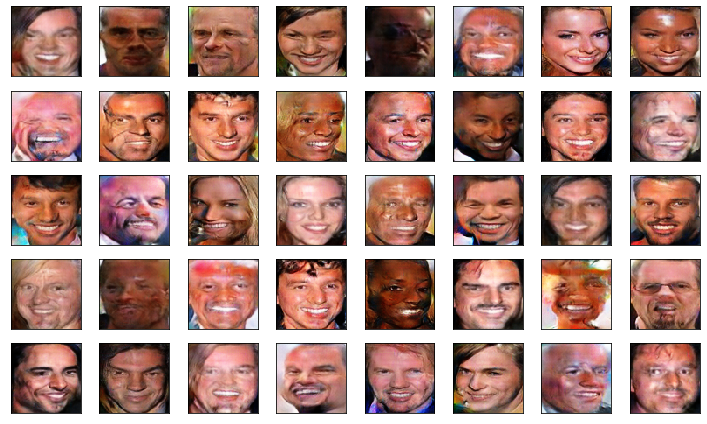

In [16]:
# generate many smiling men
points = []
indices = list(itertools.product(smiling_woman, neutral_woman, neutral_man))
random.shuffle(indices)
for sw, nw, nm in indices[0:40]:
    point = latents[sw] - latents[nw] + latents[nm]
    points.append(point)
points = np.array(points)
faces = generate_faces(generator, points)
plot_images(faces, nrow=5, ncol=8)